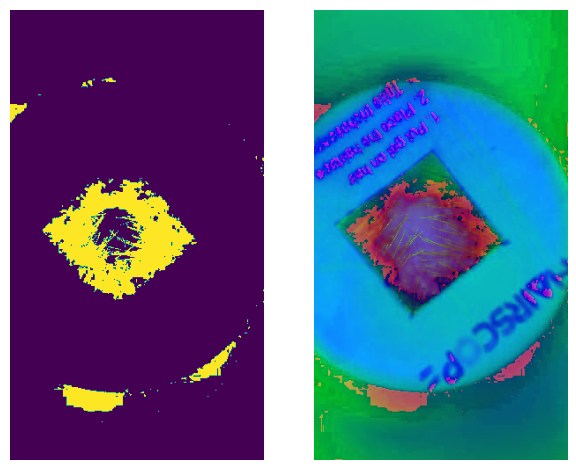

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image = cv2.imread('file.jpg')

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define HSV bounds for masking
lower_bound = np.array([ 75, 0, 0], dtype=np.uint8)
upper_bound = np.array([255,  150, 150], dtype=np.uint8)

# Create a mask using the defined bounds
mask = cv2.inRange(hsv, lower_bound, upper_bound)

# Display the mask and HSV image
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(mask)
ax[1].imshow(hsv)

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

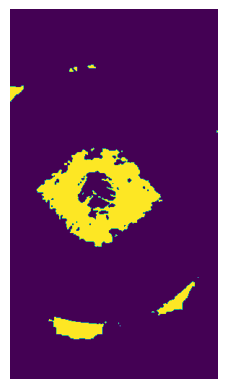

In [3]:
# Apply Gaussian blur to the mask
img = mask
blur = cv2.GaussianBlur(img,(5,5),0)

# Apply Otsu's thresholding
ret, otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Display the Otsu thresholded image
plt.imshow(otsu)
plt.axis('off')
plt.show()

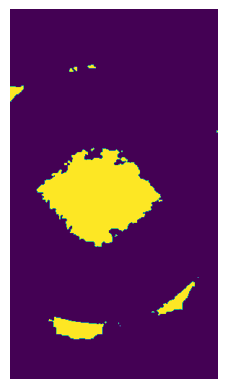

In [4]:
# Fill holes in the binary mask
from scipy.ndimage import binary_fill_holes
filled_mask = binary_fill_holes(otsu)

# Display the filled mask
plt.imshow(filled_mask)
plt.axis('off')
plt.show()

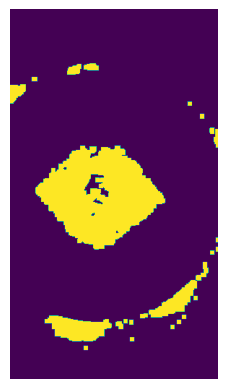

In [5]:
# Dilate the mask
kernel = np.ones((6, 6), np.uint8)
dilation = cv2.dilate(mask, kernel, iterations=1)

# Display the dilated mask
plt.imshow(dilation)
plt.axis('off')
plt.show()

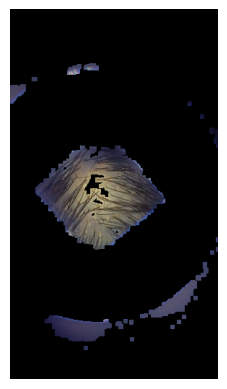

In [6]:
# Apply the dilated mask to the original image
Hn = cv2.bitwise_and(image, image, mask=dilation)

# Display the masked image
plt.imshow(Hn)
plt.axis('off')
plt.show()

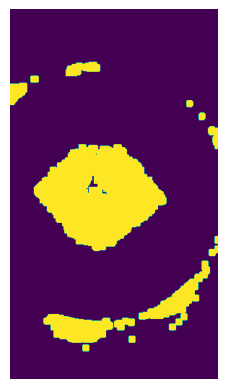

In [7]:
# Apply Gaussian blur and convert to grayscale
blur = cv2.cvtColor(cv2.GaussianBlur(Hn,(5,5),0), cv2.COLOR_BGR2GRAY)

# Display the non-zero regions of the blurred image
plt.imshow((blur!=0).astype(int))
plt.axis('off')
plt.show()

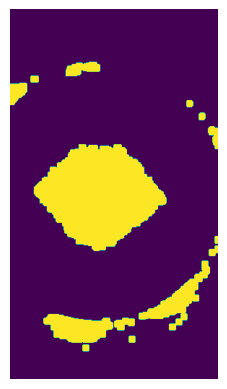

In [8]:
# Fill holes in the mask created from the blurred image
filled_mask = binary_fill_holes(blur!=0).astype(int)

# Display the filled mask
plt.imshow(filled_mask)
plt.axis('off')
plt.show()

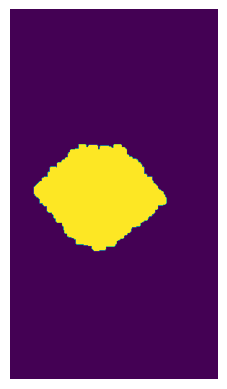

In [9]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

# Compute the Euclidean distance transform
distance = ndi.distance_transform_edt(mask)

# Find peaks in the distance transform
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=mask)

# Mark the peaks in the mask
mask = filled_mask * 255
mask[tuple(coords.T)] = True

# Label the markers
markers, _ = ndi.label(mask)

# Apply the watershed algorithm
labels = watershed(-distance, markers, mask=mask)

# Identify the largest region
max_idx = -1

for i in range(1, labels.max()):
    if np.sum(labels==i) > np.sum(labels==max_idx):
        max_idx = i

# Display the largest region
plt.imshow(labels==max_idx)
plt.axis('off')
plt.show()

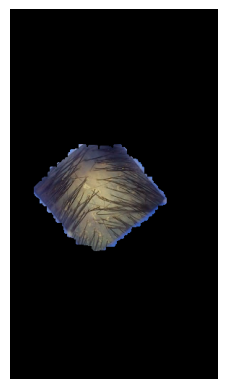

In [10]:
# Create a mask for the largest region
mask = np.repeat(np.expand_dims(labels == max_idx, axis = 2), 3, axis=2)

# Display the original image with the mask applied
plt.imshow(image * mask)
plt.axis('off')
plt.show()

In [11]:
plt.imsave("output.jpg", image * mask)